In [12]:
%%time
from joblib import Parallel, delayed
import multiprocessing

inputs = range(100000) 
def processInput(i):
    return i * i

num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
#print(results)

CPU times: user 1.41 s, sys: 29.6 ms, total: 1.44 s
Wall time: 1.43 s


In [13]:
%%time

inputs = range(100000) 
def processInput(i):
    return i * i
[processInput(i) for i in inputs];

CPU times: user 11.6 ms, sys: 727 µs, total: 12.3 ms
Wall time: 11.8 ms


[0,
 1,
 4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361,
 400,
 441,
 484,
 529,
 576,
 625,
 676,
 729,
 784,
 841,
 900,
 961,
 1024,
 1089,
 1156,
 1225,
 1296,
 1369,
 1444,
 1521,
 1600,
 1681,
 1764,
 1849,
 1936,
 2025,
 2116,
 2209,
 2304,
 2401,
 2500,
 2601,
 2704,
 2809,
 2916,
 3025,
 3136,
 3249,
 3364,
 3481,
 3600,
 3721,
 3844,
 3969,
 4096,
 4225,
 4356,
 4489,
 4624,
 4761,
 4900,
 5041,
 5184,
 5329,
 5476,
 5625,
 5776,
 5929,
 6084,
 6241,
 6400,
 6561,
 6724,
 6889,
 7056,
 7225,
 7396,
 7569,
 7744,
 7921,
 8100,
 8281,
 8464,
 8649,
 8836,
 9025,
 9216,
 9409,
 9604,
 9801,
 10000,
 10201,
 10404,
 10609,
 10816,
 11025,
 11236,
 11449,
 11664,
 11881,
 12100,
 12321,
 12544,
 12769,
 12996,
 13225,
 13456,
 13689,
 13924,
 14161,
 14400,
 14641,
 14884,
 15129,
 15376,
 15625,
 15876,
 16129,
 16384,
 16641,
 16900,
 17161,
 17424,
 17689,
 17956,
 18225,
 18496,
 18769,
 19044,
 19321,
 19600,
 19881,
 20164,
 2

In [16]:
%%time
from analysis_utils import *
import numpy as np
%load_ext autoreload
import pandas as pd
scalingFactor = 200
rxndiff=dict()

print('Starting scaling = ', scalingFactor)
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}


#Growth rate = 3.0
path = "/Users/Akshay/Documents/TranslationDynamics/data/"

gr_sim = dict()

data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data, 1e15, 1e15, 100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor, NR_scaling = NR_scaledrates)
    gr_sim[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 1e15, 1e15, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor, NR_scaling = NR_scaledrates)
    gr_sim[i] = (CellLatencies(sim_i))


gr_dict = {'gr_1':gr_sim}

def computedElongationLatency_gr3_v2(gr25_ptRNA,gr25_pCodon,gr_dict):
    import numpy as np

    transportRxnResults = transportRxnCalc(gr_dict,gr25_ptRNA,gr25_pCodon)

    search_list = transportRxnResults[0]
    rxndiff['30'] = transportRxnResults[1:]
    return([rxndiff[d][2][0]+(1000/1475+1000/1529+1000/209+1000/200+1000/32) for d in rxndiff],[rxndiff[d][5][0] for d in rxndiff])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting scaling =  200
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 53.2 s, sys: 334 ms, total: 53.5 s
Wall time: 53.9 s


In [32]:
###### Genetic algorithm for just tRNA shuffling ########

def run_ga(inputs):
    gr25_Codon = inputs[0]
    elong_t_tRNA_list = inputs[1]
    p_tRNA_list = inputs[2]
    gr_dict = inputs[3]
    mintRNA = inputs[4]
    maxtRNA = inputs[5]
    #### Compute fitness
    fitness = (1/np.array(elong_t_tRNA_list))/sum((1/np.array(elong_t_tRNA_list)))

    #### Number of candidates n removing as well as n mating to create n offspring
    n = 10

    #### Identify the least fit candidates from the population
    cull_indices = np.argpartition(fitness, n)[:n]

    #### Choose parents based on weighting fitness
    import random
    #parent_indices = np.array(random.choices(np.arange(len(p_tRNA_list)), fitness, k=10))
    parent_indices = np.argpartition(fitness, n)[-n:]
    p_tRNA_list=np.array(p_tRNA_list)
    parents = p_tRNA_list[parent_indices]

    #### Mate k random pairs of 2 without replacement and renormalize
    k=5
    couples = np.random.choice(np.arange(len(parents)), size = (k,2),replace=False)
    recombination_rate = 0.1
    mutation_rate  = 0.05

    recombined_children = list()
    recombined_children_elongt = list()
    for couple_index in couples:
        couple = parents[couple_index]
        recombination_num = int(len(couple[0])*recombination_rate)
        recombination_locs = np.random.choice(len(couple[0]),recombination_num)
        recombination_values_0 = couple[0][recombination_locs] 
        couple[0][recombination_locs] = couple[1][recombination_locs]
        couple[1][recombination_locs] = recombination_values_0
        
        #### Mutate children
        mutation_num = int(len(couple[0])*mutation_rate)
        recombination_locs = np.random.choice(len(couple[0]),mutation_num)
        couple[0][recombination_locs] = np.random.uniform(mintRNA,maxtRNA,mutation_num)
        couple[1][recombination_locs] = np.random.uniform(mintRNA,maxtRNA,mutation_num)
        
        ### Re-normalize each recombined children
        child_0 = couple[0]/np.sum(couple[0])
        child_1 = couple[1]/np.sum(couple[1])

        #### Compute elong_t of the recombined children
        elong_t_0, std_0 = computedElongationLatency_gr3_v2(child_0,gr25_pCodon,gr_dict);
        elong_t_1, std_1 = computedElongationLatency_gr3_v2(child_1,gr25_pCodon,gr_dict);
                

        ### Add children to list as well as their elong_t
        recombined_children.append(list(child_0))
        recombined_children.append(list(child_1))
        recombined_children_elongt.append(elong_t_0[0])
        recombined_children_elongt.append(elong_t_1[0])

    #### Have recombined children and their elong_t replaced culled candidates
    p_tRNA_list[cull_indices] = recombined_children
    elong_t_tRNA_list[cull_indices] = recombined_children_elongt
    return fitness, p_tRNA_list, elong_t_tRNA_list

    

In [17]:
%%time
### Codon array fixed
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)
elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
p_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_p_Codon_tRNA_list.npy')


fitness_arr = list()
minelong_arr = list()
for i in range(5):
    fitness, p_tRNA_list, elong_t_tRNA_list = run_ga(gr25_Codon,elong_t_tRNA_list,p_tRNA_list,gr_dict,min(gr25_ptRNA),max(gr25_ptRNA))
    print(max(fitness))
    print(min(elong_t_tRNA_list))
    fitness_arr.append(max(fitness))
    minelong_arr.append(min(elong_t_tRNA_list))
#np.save('RandomtRNA_FixedCodon_1500sample_elong_t_list2',elong_t_tRNA_list)
#np.save('RandomtRNA_FixedCodon_1500sample_p_tRNA_list2',p_tRNA_list)
#np.save('minelong_arr2',minelong_arr)

0.010488399408659985
200.29460396853858
0.010462810190748998
199.63800155525678
0.010461305463861686
199.63800155525678
0.01043004218575482
199.63800155525678
0.01040257025311234
199.63800155525678
CPU times: user 1min, sys: 93.3 ms, total: 1min
Wall time: 1min


In [41]:
%%time
### Codon array fixed
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)
elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
p_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_p_Codon_tRNA_list.npy')
num_cores = multiprocessing.cpu_count()


fitness_arr = list()
minelong_arr = list()
inputs=[[gr25_Codon,elong_t_tRNA_list,p_tRNA_list,gr_dict,min(gr25_ptRNA),max(gr25_ptRNA)] for i in np.arange(10)]
a = Parallel(n_jobs=num_cores)(delayed(run_ga)(i) for i in inputs)

CPU times: user 812 ms, sys: 13.6 ms, total: 826 ms
Wall time: 20.8 s


In [40]:
a[-1]

(array([0.01025695, 0.01025889, 0.00991592, 0.0097242 , 0.01047329,
        0.01018051, 0.0100449 , 0.00991433, 0.01018902, 0.00999324,
        0.00998941, 0.0100063 , 0.01001696, 0.00999541, 0.00991518,
        0.00978466, 0.01020558, 0.01009889, 0.00955582, 0.00999364,
        0.01032258, 0.00982186, 0.00988973, 0.00977592, 0.00984341,
        0.01001121, 0.00971704, 0.00984699, 0.01003527, 0.01025785,
        0.0098496 , 0.01030712, 0.00956724, 0.00987935, 0.0102183 ,
        0.01042032, 0.01000507, 0.00999389, 0.00978918, 0.00971627,
        0.00978166, 0.00995403, 0.01007951, 0.00974809, 0.01030651,
        0.01018699, 0.00980783, 0.010071  , 0.00988622, 0.00973007,
        0.01001445, 0.01038985, 0.00997942, 0.00965501, 0.00980629,
        0.01032395, 0.01006947, 0.01025902, 0.00973368, 0.01020464,
        0.0097288 , 0.01014414, 0.00989785, 0.0098861 , 0.01036359,
        0.00985459, 0.01008461, 0.01036713, 0.00967438, 0.00998479,
        0.0098157 , 0.00992717, 0.00974273, 0.01

500


ValueError: x and y must have same first dimension, but have shapes (1500,) and (500,)

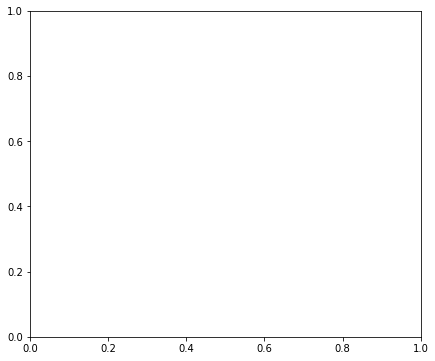

In [72]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2.npy')
fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(1500),minelong,linewidth=4,color='blue')
ax.plot(np.arange(1500),[186.4]*1500,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(-20,1500)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

Text(0.5, 0, 'Epoch')

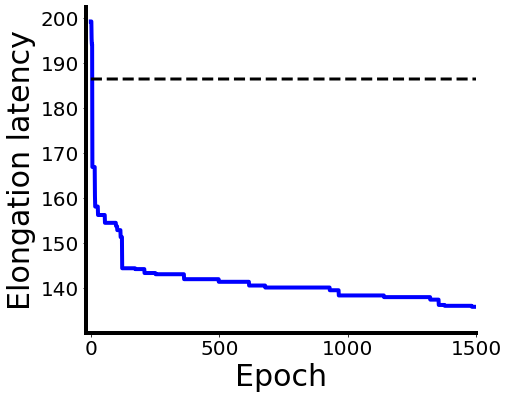

In [69]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2-RandomCodon.npy')

fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(2000),minelong,linewidth=4,color='blue')
ax.plot(np.arange(2000),[186.4]*2000,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(-20,1500)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

Text(0.5, 0, 'Epoch')

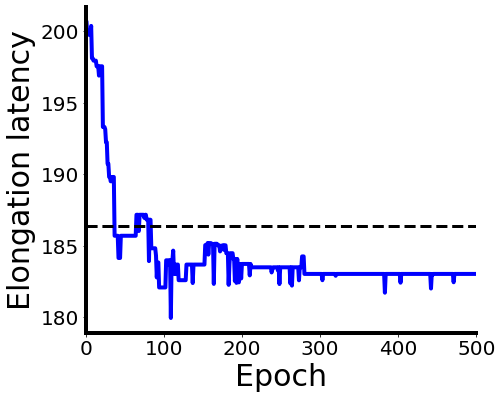

In [64]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2.npy')

fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(500),minelong,linewidth=4,color='blue')
ax.plot(np.arange(500),[186.4]*500,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(0,500)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

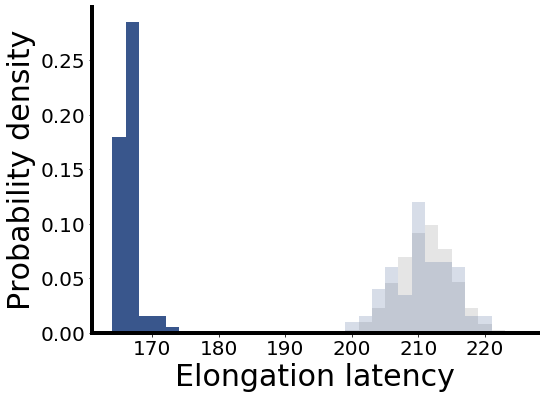

In [200]:
fig,ax = plt.subplots(figsize=(8,6))
#ax.fill_between(np.linspace(160,186.4,2), [0]*2,max(hist[0])*2,alpha=0.1,color='green')


#hist=ax.hist(elong_t_tRNA_list,20,color='grey',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')


p_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_p_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_elong_t_list.npy')


hist=ax.hist(elong_t_tRNA_list,15,range=(164,194),color='#39568CFF',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')

p_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')

elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.2)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)

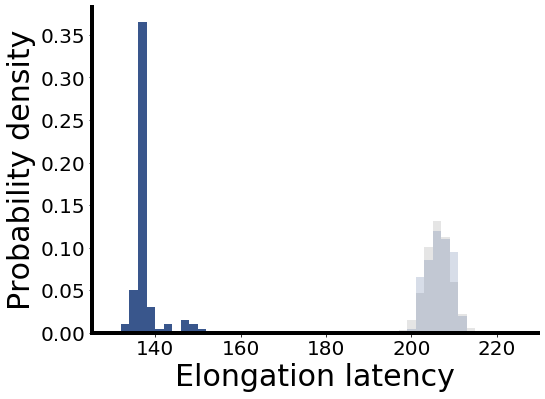

In [205]:
fig,ax = plt.subplots(figsize=(8,6))
#ax.fill_between(np.linspace(160,186.4,2), [0]*2,max(hist[0])*2,alpha=0.1,color='green')


#hist=ax.hist(elong_t_tRNA_list,20,color='grey',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')


p_tRNA_list=np.load('FixedtRNA_RandomCodon_2000sample_p_tRNA_list.npy')
elong_t_tRNA_list=np.load('FixedtRNA_RandomCodon_2000sample_elong_t_list.npy')

hist=ax.hist(elong_t_tRNA_list,15,range=(130,160),color='#39568CFF',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')

p_tRNA_list=np.load('FixedtRNA_RandomCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('FixedtRNA_RandomCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')

elong_t_tRNA_list = np.load('FixedtRNA_RandomCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.2)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)